# Dice Detection Project
Dice detection project for Computer Vision (include description)

## 1. Import Dependencies

In [1]:
import os
import shutil
from concurrent.futures import ThreadPoolExecutor

import kagglehub
from ultralytics import YOLO

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

Project constants

In [2]:
path = kagglehub.dataset_download("nellbyler/d6-dice")
print("Path to dataset files:", path)

# ANNOTATION_PATH = path + "/d6-dice/Annotations"
# IMAGE_PATH = path + "/d6-dice/Images"

ANNOTATION_PATH = os.path.join(path, "d6-dice", "Annotations")
IMAGE_PATH = os.path.join(path, "d6-dice", "Images")

# windows delim
split_char = '\\'

# linux delim
#split_char = '/'

Path to dataset files: C:\Users\leeal\.cache\kagglehub\datasets\nellbyler\d6-dice\versions\3


## 2. Split data into train/test/validation

In [394]:
anotation_files = []
for dir,_,files in os.walk(ANNOTATION_PATH):
    for filename in files:
        if filename[-4:] == '.txt':
            anotation_files += [(os.path.join(dir,filename))]

# remove classes.txt file from image pool
anotation_files.pop(0)

# 70/15/15 train-test split
train_ratio = .7
test_ratio = (1.0 - train_ratio) / 2
valid_ratio = test_ratio

SIZE = len(anotation_files)
N = list(range(SIZE))
# random.suffle(N)

train_size = int(SIZE * train_ratio)
test_size = int(SIZE * test_ratio)
valid_size = int(SIZE * valid_ratio)

# get indexes of split list
#train_i = N[:train_size]
#valid_i = N[train_size:(train_size + valid_size)]
#test_i = N[train_size+valid_size:]

# Add any files that might have been accidentally skipped to the train set
while((train_size + test_size + valid_size) < len(anotation_files)):
    train_size += 1

print(train_size)
print(test_size)
print(valid_size)
print(len(anotation_files))

176
37
37
250


## 3. Organize and prep data for YOLO

In [395]:
# Create directories if they don't exist
os.makedirs('datasets/train/images', exist_ok=True)
os.makedirs('datasets/train/labels', exist_ok=True)

os.makedirs('datasets/test/images', exist_ok=True)
os.makedirs('datasets/test/labels', exist_ok=True)

os.makedirs('datasets/valid/images', exist_ok=True)
os.makedirs('datasets/valid/labels', exist_ok=True)

# helper to organize files into their respective directories
def copy_files(i, dir, ano_files):
    # get the image filename
    ano_file = ano_files[i]
    img_file = ano_file.split(split_char)[-1][0:-4] + '.jpg'

    # copy into folders
    shutil.copy(ano_file, dir + '/labels')
    shutil.copy(os.path.join(IMAGE_PATH, img_file), os.path.join(dir + '/images/', img_file))

# copy image and label files into local directories
for i in range(train_size):
    copy_files(i, './datasets/train', anotation_files)

test_start = train_size + valid_size
test_end = test_start + test_size
for i in range(test_start, test_end):
    copy_files(i, './datasets/test', anotation_files)


valid_start = train_size
valid_end = valid_start + valid_size
for i in range(valid_start, valid_end):
    copy_files(i, './datasets/valid', anotation_files)

In [396]:
import yaml

source_path = current_directory = os.getcwd()

train_path = os.path.join(source_path, "datasets", "train")
test_path = os.path.join(source_path, "datasets", "test")
valid_path = os.path.join(source_path, "datasets", "valid")

data_yaml = dict(
    train = train_path,
    test = test_path,
    val = valid_path,
    
    nc = 6,
    names = list('123456'),
)

with open('data.yaml', 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=True)

In [3]:
# load model
model = YOLO("yolo11x.pt")  # build from YAML and transfer weights

## 4. Train Model

In [401]:
train_results = model.train(
    data = "./data.yaml",
    epochs = 20,
    imgsz = 480
)

New https://pypi.org/project/ultralytics/8.3.40 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.34  Python-3.11.5 torch-2.5.1+cpu CPU (AMD Ryzen 9 5900HS with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolo11x.pt, data=./data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=480, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fa

train: Scanning C:\Users\leeal\OneDrive - Virginia Tech\School\Computer Vision\DiceRollDetection\datasets\train\labels.cache... 224 images, 0 backgrounds, 0 corrupt: 100%|██████████| 224/224 [00:00<?, ?it/s]
val: Scanning C:\Users\leeal\OneDrive - Virginia Tech\School\Computer Vision\DiceRollDetection\datasets\valid\labels.cache... 82 images, 0 backgrounds, 0 corrupt: 100%|██████████| 82/82 [00:00<?, ?it/s]


Plotting labels to c:\Users\leeal\OneDrive - Virginia Tech\School\Computer Vision\DiceRollDetection\runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
Image sizes 480 train, 480 val
Using 0 dataloader workers
Logging results to c:\Users\leeal\OneDrive - Virginia Tech\School\Computer Vision\DiceRollDetection\runs\detect\train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G        1.5        2.5      1.051        123        480: 100%|██████████| 14/14 [07:36<00:00, 32.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:26<00:53, 26.73s/it]

WARNING  NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:09<00:00, 23.06s/it]

                   all         82        517      0.168      0.763      0.226      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G      1.299      1.608     0.9976        157        480: 100%|██████████| 14/14 [07:18<00:00, 31.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING  NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:27<00:54, 27.49s/it]

WARNING  NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:54<00:27, 27.31s/it]

WARNING  NMS time limit 2.900s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:10<00:00, 23.50s/it]

                   all         82        517      0.168      0.763      0.226      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G       1.31      1.377     0.9827        151        480: 100%|██████████| 14/14 [07:10<00:00, 30.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING  NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:27<00:54, 27.05s/it]

WARNING  NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:54<00:27, 27.47s/it]

WARNING  NMS time limit 2.900s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:11<00:00, 23.69s/it]

                   all         82        517      0.168      0.763      0.226      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G      1.326      1.153      1.003        194        480: 100%|██████████| 14/14 [07:12<00:00, 30.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:03<00:00, 21.19s/it]

                   all         82        517      0.167    0.00556     0.0843     0.0337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G      1.347      1.153     0.9914        125        480: 100%|██████████| 14/14 [07:12<00:00, 30.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:59<00:00, 19.98s/it]

                   all         82        517      0.565      0.327       0.36      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         0G      1.325      1.047     0.9914        214        480: 100%|██████████| 14/14 [07:10<00:00, 30.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:03<00:00, 21.25s/it]

                   all         82        517       0.45      0.214      0.257      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         0G       1.35     0.9525      1.004        170        480: 100%|██████████| 14/14 [07:12<00:00, 30.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING  NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:27<00:54, 27.48s/it]

WARNING  NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:54<00:27, 27.26s/it]

WARNING  NMS time limit 2.900s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:10<00:00, 23.49s/it]

                   all         82        517    0.00142      0.011   0.000721   0.000306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         0G      1.242     0.8776     0.9763         85        480: 100%|██████████| 14/14 [07:10<00:00, 30.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING  NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:27<00:54, 27.31s/it]

WARNING  NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:54<00:27, 27.17s/it]

WARNING  NMS time limit 2.900s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:10<00:00, 23.47s/it]

                   all         82        517      0.661     0.0493      0.315      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         0G      1.272      0.846     0.9727        181        480: 100%|██████████| 14/14 [07:12<00:00, 30.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING  NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:27<00:55, 27.67s/it]

WARNING  NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:54<00:27, 27.34s/it]

WARNING  NMS time limit 2.900s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:10<00:00, 23.59s/it]

                   all         82        517      0.661     0.0493      0.315      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         0G      1.287     0.7575     0.9656        136        480: 100%|██████████| 14/14 [07:08<00:00, 30.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:59<00:00, 19.95s/it]

                   all         82        517      0.946      0.958      0.982      0.643


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         0G       1.21     0.6155      0.999         99        480: 100%|██████████| 14/14 [07:09<00:00, 30.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:59<00:00, 19.79s/it]

                   all         82        517      0.969      0.957      0.987       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         0G      1.225     0.6064      1.013         92        480: 100%|██████████| 14/14 [07:10<00:00, 30.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:00<00:00, 20.06s/it]

                   all         82        517      0.907      0.716      0.863       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         0G      1.231     0.5852      1.002        100        480: 100%|██████████| 14/14 [07:09<00:00, 30.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:00<00:00, 20.02s/it]

                   all         82        517      0.969      0.963      0.985      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20         0G      1.197     0.5457      1.015        122        480: 100%|██████████| 14/14 [07:08<00:00, 30.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:59<00:00, 19.83s/it]

                   all         82        517      0.986      0.969      0.989      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         0G      1.195     0.5543     0.9855        120        480: 100%|██████████| 14/14 [07:11<00:00, 30.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:00<00:00, 20.17s/it]

                   all         82        517       0.98      0.974       0.99      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20         0G      1.185     0.5341      1.004        117        480: 100%|██████████| 14/14 [07:11<00:00, 30.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:00<00:00, 20.23s/it]

                   all         82        517       0.97      0.977      0.988      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         0G      1.184     0.5288      0.981         95        480: 100%|██████████| 14/14 [07:11<00:00, 30.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:59<00:00, 19.85s/it]

                   all         82        517      0.978       0.97      0.989      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20         0G       1.15     0.5201     0.9807        120        480: 100%|██████████| 14/14 [07:10<00:00, 30.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:00<00:00, 20.12s/it]

                   all         82        517      0.981      0.973      0.987      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         0G      1.148     0.4993     0.9753         96        480: 100%|██████████| 14/14 [07:12<00:00, 30.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:59<00:00, 19.94s/it]

                   all         82        517      0.974      0.983       0.99      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20         0G      1.142     0.4874      0.984        123        480: 100%|██████████| 14/14 [07:12<00:00, 30.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:00<00:00, 20.04s/it]

                   all         82        517      0.985      0.985      0.989      0.686



20 epochs completed in 2.769 hours.
Optimizer stripped from c:\Users\leeal\OneDrive - Virginia Tech\School\Computer Vision\DiceRollDetection\runs\detect\train\weights\last.pt, 114.4MB
Optimizer stripped from c:\Users\leeal\OneDrive - Virginia Tech\School\Computer Vision\DiceRollDetection\runs\detect\train\weights\best.pt, 114.4MB

Validating c:\Users\leeal\OneDrive - Virginia Tech\School\Computer Vision\DiceRollDetection\runs\detect\train\weights\best.pt...
Ultralytics 8.3.34  Python-3.11.5 torch-2.5.1+cpu CPU (AMD Ryzen 9 5900HS with Radeon Graphics)
YOLO11x summary (fused): 464 layers, 56,833,954 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:52<00:00, 17.43s/it]


                   all         82        517      0.984      0.986      0.989      0.686
                     1         61         97      0.994          1      0.995      0.679
                     2         52         92      0.989      0.978      0.991      0.707
                     3         49         86      0.977      0.998      0.986      0.671
                     4         51         71      0.968      0.972      0.983      0.688
                     5         57         92      0.989      0.982      0.987      0.677
                     6         47         79      0.991      0.987      0.995      0.695
Speed: 2.8ms preprocess, 591.2ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to c:\Users\leeal\OneDrive - Virginia Tech\School\Computer Vision\DiceRollDetection\runs\detect\train


## 5. Masking

In [4]:
pred_dataset_path = kagglehub.dataset_download("koryakinp/d6-dices-images")

dataset_images = os.path.join(pred_dataset_path, "dataset-images")

print(pred_dataset_path)

image_dir = os.listdir(os.path.join(pred_dataset_path, 'dataset-images'))
image_list = []
for file in image_dir:
    image_list.append(os.path.join(pred_dataset_path,'dataset-images', file))

print(image_list[0])

C:\Users\leeal\.cache\kagglehub\datasets\koryakinp\d6-dices-images\versions\2
C:\Users\leeal\.cache\kagglehub\datasets\koryakinp\d6-dices-images\versions\2\dataset-images\0001091d-6438-4cc3-bb80-a79534f9ccd8.jpg


In [5]:
masked_images = []

Mask images

In [6]:
os.makedirs('test_images/masked_images', exist_ok=True)

def save_im(image_path, result):
    cv2.imwrite(image_path, result)

with ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for i in range(len(image_list)):
        image = cv2.imread(image_list[i])
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        _, dice_mask = cv2.threshold(gray_image, 125, 255, cv2.THRESH_BINARY_INV)
        result = cv2.bitwise_and(image, image, mask=dice_mask)
        result[dice_mask == 0] = [255, 255, 255]
        result[dice_mask != 0] = [0, 0, 0]

        #plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        #plt.axis("off")
        #plt.title("Masked Dice")
        #plt.show()
        #masked_images.append(result)

        image_name = 'masked_image'+str(i)+'.jpg'

        im_name = os.path.join('test_images', 'masked_images', image_name)
        masked_images.append(im_name)

        # output to file
        #futures.append(executor.submit(save_im, im_name, result))

    # wait to retrieve all futures
    for future in futures:
        future.result()

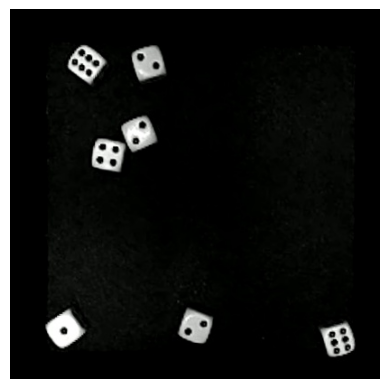

In [7]:
def show_image(image_path):
    # Load the image from the directory
    image = Image.open(image_path)

    # Display the image using matplotlib
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()

show_image(image_list[0])

## 6. Predict Using a Different Dataset

In [8]:
def get_results(results, image_list, file_name):
    keys = [0, 1, 2, 3, 4, 5]
    values = [1, 2, 3, 4, 5, 6]

    image_list = sorted(image_list)

    class_dict = dict(zip(keys, values))

    data = pd.DataFrame(columns= range(6))
    for i in range(len(results)):
        # add the data to a Data Frame
        result = pd.DataFrame(results[i].boxes.data.cpu().numpy()).astype(float)
        
        # append the 
        file = image_list[i]
        result['img index'] = int(i)
        result['file'] = file

        data = pd.concat([data, result], axis=0)

    # rename columns
    data.columns = ['x', 'y', 'x2', 'y2', 'cl', 'label', 'i', 'file']

    # apply correct labellings
    data['label'] = data['label'].map(class_dict)
    data['i'] = data['i'].astype(int)
    data = data.reset_index(drop=True)

    # output data
    os.makedirs("results", exist_ok=True)
    data.to_csv(os.path.join("results", "data", file_name + ".csv"), index=False, header=True)

    display(data)
    
    return data

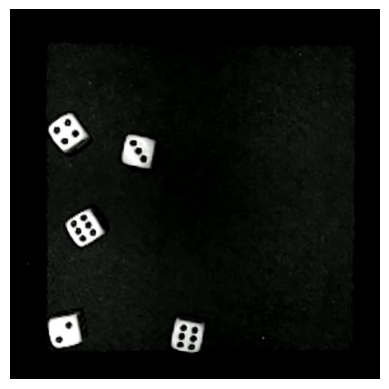

In [29]:
show_image(image_list[8])

Predict bounding boxes and values of the dice in another dataset

In [9]:
trained_model = YOLO(os.path.join("runs", "detect", "train19", "weights", "best.pt"))
trained_model_e20 = YOLO(os.path.join("runs", "detect", "train", "weights", "best.pt"))

Predict with epoch = 12

In [ ]:
results = trained_model.predict(source=image_list[:20], conf=0.2)
results_masked = trained_model.predict(source=masked_images[:20], conf=0.2)


0: 480x480 2 1s, 3 2s, 1 4, 2 6s, 574.4ms
1: 480x480 1 1, 2 2s, 1 3, 2 4s, 1 5, 1 6, 574.4ms
2: 480x480 1 1, 1 2, 2 3s, 2 4s, 2 5s, 574.4ms
3: 480x480 1 1, 2 3s, 1 4, 3 5s, 2 6s, 574.4ms
4: 480x480 3 1s, 2 2s, 1 4, 1 5, 1 6, 574.4ms
5: 480x480 1 1, 3 2s, 2 5s, 2 6s, 574.4ms
6: 480x480 1 1, 1 2, 1 3, 1 5, 2 6s, 574.4ms
7: 480x480 1 1, 2 3s, 1 4, 3 5s, 574.4ms
8: 480x480 1 2, 1 3, 1 4, 2 6s, 574.4ms
9: 480x480 3 2s, 2 3s, 2 5s, 574.4ms
10: 480x480 1 1, 2 4s, 1 5, 3 6s, 574.4ms
11: 480x480 1 1, 1 2, 2 3s, 2 4s, 1 5, 574.4ms
12: 480x480 3 1s, 3 2s, 1 4, 1 5, 574.4ms
13: 480x480 3 1s, 1 2, 1 3, 2 6s, 574.4ms
14: 480x480 2 1s, 2 3s, 2 4s, 2 5s, 574.4ms
15: 480x480 1 1, 2 2s, 2 3s, 1 4, 1 6, 574.4ms
16: 480x480 1 1, 2 3s, 1 4, 1 5, 574.4ms
17: 480x480 1 2, 2 3s, 3 4s, 1 5, 574.4ms
18: 480x480 2 1s, 2 2s, 1 3, 2 6s, 574.4ms
19: 480x480 2 1s, 5 6s, 574.4ms
Speed: 2.0ms preprocess, 574.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 480)

0: 480x480 3 1s, 2 2s, 1 4, 2 6s, 561.5m

Predict with epoch=20

In [15]:
results_e20 = trained_model_e20.predict(source=image_list[:20], conf=0.2)
results_e20_masked = trained_model_e20.predict(source=masked_images[:20], conf=0.2)


0: 480x480 1 1, 3 2s, 1 4, 2 6s, 546.9ms
1: 480x480 2 2s, 1 3, 2 4s, 1 5, 1 6, 546.9ms
2: 480x480 1 2, 2 3s, 2 4s, 2 5s, 546.9ms
3: 480x480 1 1, 2 3s, 2 4s, 1 5, 2 6s, 546.9ms
4: 480x480 1 1, 2 2s, 1 4, 1 5, 1 6, 546.9ms
5: 480x480 3 2s, 2 5s, 2 6s, 546.9ms
6: 480x480 1 1, 1 2, 1 3, 1 4, 1 5, 2 6s, 546.9ms
7: 480x480 1 1, 2 3s, 1 4, 4 5s, 546.9ms
8: 480x480 1 2, 1 3, 1 4, 1 5, 2 6s, 546.9ms
9: 480x480 3 2s, 2 3s, 2 5s, 1 6, 546.9ms
10: 480x480 2 4s, 1 5, 2 6s, 546.9ms
11: 480x480 1 2, 3 3s, 1 4, 1 5, 546.9ms
12: 480x480 2 1s, 3 2s, 1 4, 1 5, 546.9ms
13: 480x480 3 1s, 1 2, 1 3, 2 6s, 546.9ms
14: 480x480 2 1s, 1 3, 2 4s, 2 5s, 546.9ms
15: 480x480 2 2s, 2 3s, 1 4, 1 6, 546.9ms
16: 480x480 1 1, 2 3s, 1 4, 1 5, 546.9ms
17: 480x480 1 2, 2 3s, 3 4s, 1 5, 546.9ms
18: 480x480 1 1, 2 2s, 1 3, 1 4, 2 6s, 546.9ms
19: 480x480 2 1s, 5 6s, 546.9ms
Speed: 2.3ms preprocess, 546.9ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 480)

0: 480x480 1 1, 2 2s, 1 3, 1 4, 2 6s, 538.3ms
1: 480x48

Generate Data Frames

In [16]:
os.makedirs(os.path.join("results","data"), exist_ok=True)

orig_df = get_results(results, image_list, "orig_e12")
masked_df = get_results(results_masked, masked_images, "masked_e12")

orig_df_e20 = get_results(results_e20, image_list, "orig_e20")
masked_df_e20 = get_results(results_e20_masked, masked_images, "masked_e20")

C:\Users\leeal\AppData\Local\Temp\ipykernel_22996\32278569.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, result], axis=0)


,x,y,x2,y2,cl,label,i,file
0,85.956535,141.269653,130.124985,186.964828,0.916102,4,0,C:\Users\leeal\.cache\kagglehub\datasets\korya...
1,340.447662,344.211578,386.485809,389.874268,0.853071,6,0,C:\Users\leeal\.cache\kagglehub\datasets\korya...
2,60.501671,37.584240,107.788902,86.368271,0.820382,6,0,C:\Users\leeal\.cache\kagglehub\datasets\korya...
3,36.548065,331.706299,85.416512,379.563141,0.786982,1,0,C:\Users\leeal\.cache\kagglehub\datasets\korya...
4,182.049759,329.882111,228.512970,376.264862,0.753410,2,0,C:\Users\leeal\.cache\kagglehub\datasets\korya...
...,...,...,...,...,...,...,...,...
139,195.161377,254.241119,241.793045,302.875854,0.849534,6,19,C:\Users\leeal\.cache\kagglehub\datasets\korya...
140,147.901520,337.410645,195.639862,384.978638,0.848122,1,19,C:\Users\leeal\.cache\kagglehub\datasets\korya...
141,49.383999,76.250816,95.987831,124.704964,0.831824,6,19,C:\Users\leeal\.cache\kagglehub\datasets\korya...
142,41.437641,201.946136,90.939857,251.973175,0.825250,6,19,C:\Users\leeal\.cache\kagglehub\datasets\korya...


C:\Users\leeal\AppData\Local\Temp\ipykernel_22996\32278569.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, result], axis=0)


,x,y,x2,y2,cl,label,i,file
0,341.278015,345.780731,386.588379,389.460144,0.863240,6,0,test_images\masked_images\masked_image0.jpg
1,60.296967,37.599270,107.444344,85.423668,0.855326,6,0,test_images\masked_images\masked_image0.jpg
2,86.317871,141.089081,129.242325,185.826248,0.810191,4,0,test_images\masked_images\masked_image0.jpg
3,36.781658,331.356293,85.406960,379.582428,0.785843,1,0,test_images\masked_images\masked_image0.jpg
4,120.439240,116.825806,164.676773,160.845673,0.705994,2,0,test_images\masked_images\masked_image0.jpg
...,...,...,...,...,...,...,...,...
153,49.360149,75.983650,95.653351,122.419006,0.829284,6,19,test_images\masked_images\masked_image10013.jpg
154,148.012527,338.360474,195.030334,384.598511,0.803652,1,19,test_images\masked_images\masked_image10013.jpg
155,225.624039,70.935616,268.048767,112.494324,0.780874,1,19,test_images\masked_images\masked_image10013.jpg
156,51.690773,31.286892,98.851494,78.044189,0.728702,6,19,test_images\masked_images\masked_image10013.jpg


C:\Users\leeal\AppData\Local\Temp\ipykernel_22996\32278569.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, result], axis=0)


,x,y,x2,y2,cl,label,i,file
0,87.118317,142.630295,130.873169,184.464722,0.800046,4,0,C:\Users\leeal\.cache\kagglehub\datasets\korya...
1,61.667900,37.319054,108.523239,85.420593,0.785942,6,0,C:\Users\leeal\.cache\kagglehub\datasets\korya...
2,340.575500,345.113770,386.287811,389.223938,0.776315,6,0,C:\Users\leeal\.cache\kagglehub\datasets\korya...
3,120.720566,116.528847,165.515213,162.258102,0.694320,2,0,C:\Users\leeal\.cache\kagglehub\datasets\korya...
4,36.685898,332.328247,86.020790,380.979187,0.659857,1,0,C:\Users\leeal\.cache\kagglehub\datasets\korya...
...,...,...,...,...,...,...,...,...
130,41.968754,203.541992,89.944633,251.713837,0.782694,6,19,C:\Users\leeal\.cache\kagglehub\datasets\korya...
131,195.610748,255.562439,242.129456,301.984955,0.779430,6,19,C:\Users\leeal\.cache\kagglehub\datasets\korya...
132,225.899902,70.538116,267.567749,112.325294,0.769258,1,19,C:\Users\leeal\.cache\kagglehub\datasets\korya...
133,52.517334,31.086296,100.734703,79.576675,0.715525,6,19,C:\Users\leeal\.cache\kagglehub\datasets\korya...


C:\Users\leeal\AppData\Local\Temp\ipykernel_22996\32278569.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, result], axis=0)


,x,y,x2,y2,cl,label,i,file
0,341.888031,345.688629,385.842499,389.410492,0.749480,6,0,test_images\masked_images\masked_image0.jpg
1,86.576424,142.208176,130.086639,184.462006,0.680652,4,0,test_images\masked_images\masked_image0.jpg
2,120.928398,117.393730,164.547470,160.813354,0.640974,2,0,test_images\masked_images\masked_image0.jpg
3,61.538177,38.325363,107.871407,85.785286,0.594684,6,0,test_images\masked_images\masked_image0.jpg
4,36.863861,331.078369,85.367714,380.535187,0.538427,1,0,test_images\masked_images\masked_image0.jpg
...,...,...,...,...,...,...,...,...
131,196.230728,257.437805,240.509598,300.688141,0.606480,6,19,test_images\masked_images\masked_image10013.jpg
132,149.528915,338.827515,195.255661,384.067169,0.577012,1,19,test_images\masked_images\masked_image10013.jpg
133,226.494629,70.835983,267.274841,112.064598,0.447334,1,19,test_images\masked_images\masked_image10013.jpg
134,52.887516,30.625257,99.974594,77.998772,0.430377,5,19,test_images\masked_images\masked_image10013.jpg


## 7. Remove duplicate bounding boxes

Helper Functions

In [13]:
def coincides(b1, b2, scale=0.1):
    # bounding box (BB) 1 diagonal length
    p1 = np.array([b1[0], b1[1]])
    p2 = np.array([b1[2], b1[3]])
    threshold = np.linalg.norm(p1 - p2) * scale

    # distance between BB 1 and BB 2
    p1 = np.array([b1[0], b1[1]])
    p2 = np.array([b2[0], b2[1]])
    dist = np.linalg.norm(p1 - p2)
    
    return dist < threshold

Removal of Extra Bounding Boxes

In [14]:
# compare bounding boxes
def compare_boxes(data, cl):
    remove_idx = []
    for i in range(len(data)):
        # if data was already removed, then skip
        if i in remove_idx:
            continue
        
        # obtain first bounding box
        b1 = data[i]

        for j in range(len(data)):
            # if data was already removed, then skip
            if j in remove_idx:
                continue

            # obtain second bounding box
            b2 = data[j]

            if np.array_equiv(b1, b2):
                continue
            
            # if 2 bounding boxes coincide, then take the value with the higher confidence level
            if coincides(b1, b2):
                remove_idx.append(j if cl[i] > cl[j] else i)
    
    return remove_idx

# remove any duplicate bounding boxes
def remove_dup_BB(df):
    max_index = df.iloc[-1]['i'] + 1

    offset = 0
    remove_idx = []
    for index in range(max_index):
        # remove the label, confidence level, image index, and image path
        view = df[df['i'] == index].iloc[:, :-4]
        cl = df[df['i'] == index]['cl']
        cl = cl.reset_index(drop=True)

        # remove duplicate bounding boxes
        dup_idx = compare_boxes(view.to_numpy(), cl)
        dup_idx = [i + offset for i in dup_idx]

        remove_idx.extend(dup_idx)

        # increment offset
        offset = offset + len(view)

    # filter out wrong bounding boxes
    if remove_idx:
        filtered_df = df.drop(remove_idx)
    else:
        return df

    return filtered_df

Output dataframe to csv

In [18]:
os.makedirs(os.path.join("results","filtered"), exist_ok=True)

filtered_orig_e12_df = remove_dup_BB(orig_df)
filtered_orig_e12_df.to_csv(os.path.join("results", "filtered", "filtered_orig.csv"), index=False, header=True)

filtered_orig_e20_df = remove_dup_BB(orig_df_e20)
filtered_orig_e20_df.to_csv(os.path.join("results", "filtered", "filtered_orig_e20.csv"), index=False, header=True)

filtered_mask_e12_df = remove_dup_BB(masked_df)
filtered_mask_e12_df.to_csv(os.path.join("results", "filtered", "filtered_masked.csv"), index=False, header=True)

filtered_mask_e20_df = remove_dup_BB(masked_df_e20)
filtered_mask_e20_df.to_csv(os.path.join("results", "filtered", "filtered_masked_e20.csv"), index=False, header=True)

show removed results

In [20]:
# display difference
def show_diff(orig, filt):
    display(pd.concat([orig, filt]).drop_duplicates(keep=False))

print("epoch=12")
show_diff(orig_df, filtered_orig_e12_df)
show_diff(masked_df, filtered_mask_e12_df)

print("epoch=20")
show_diff(orig_df_e20, filtered_orig_e20_df)
show_diff(masked_df_e20, filtered_mask_e20_df)

epoch=12


,x,y,x2,y2,cl,label,i,file
7,182.867325,329.296265,228.352982,375.429443,0.311292,1,0,C:\Users\leeal\.cache\kagglehub\datasets\korya...
15,293.601593,39.504642,336.261536,86.065170,0.467241,1,1,C:\Users\leeal\.cache\kagglehub\datasets\korya...
23,311.200775,150.989883,355.813049,196.780502,0.541180,2,2,C:\Users\leeal\.cache\kagglehub\datasets\korya...
31,158.633911,232.173187,206.911957,280.689362,0.630582,3,3,C:\Users\leeal\.cache\kagglehub\datasets\korya...
32,262.049561,261.384918,310.745941,309.950409,0.433672,5,3,C:\Users\leeal\.cache\kagglehub\datasets\korya...
40,331.211151,306.272095,376.156158,351.167664,0.429408,1,4,C:\Users\leeal\.cache\kagglehub\datasets\korya...
48,223.796005,167.357056,268.802094,213.346039,0.430681,1,5,C:\Users\leeal\.cache\kagglehub\datasets\korya...
80,134.570480,279.650391,181.592773,327.140381,0.290704,6,10,C:\Users\leeal\.cache\kagglehub\datasets\korya...
86,281.926941,234.138519,329.306793,282.796570,0.422397,1,11,C:\Users\leeal\.cache\kagglehub\datasets\korya...
95,116.315254,98.657219,158.854095,141.012863,0.356131,2,12,C:\Users\leeal\.cache\kagglehub\datasets\korya...


,x,y,x2,y2,cl,label,i,file
7,131.477814,37.849247,175.408066,84.078323,0.446201,1,0,test_images\masked_images\masked_image0.jpg
14,292.732330,39.797398,335.736664,82.992844,0.312100,2,1,test_images\masked_images\masked_image1.jpg
16,34.391430,131.085190,79.990425,179.181534,0.230222,2,1,test_images\masked_images\masked_image1.jpg
21,35.779701,260.357086,83.413696,308.149658,0.604290,3,2,test_images\masked_images\masked_image10.jpg
25,81.431740,338.734558,128.795944,387.642273,0.426063,2,2,test_images\masked_images\masked_image10.jpg
26,230.540085,169.745926,272.388245,213.886017,0.295376,5,2,test_images\masked_images\masked_image10.jpg
27,327.786255,62.622322,374.045807,111.004555,0.200963,2,2,test_images\masked_images\masked_image10.jpg
41,34.897408,207.581116,81.819344,253.730988,0.536221,3,4,test_images\masked_images\masked_image1000.jpg
42,262.411285,247.099518,306.017456,290.837616,0.398764,1,4,test_images\masked_images\masked_image1000.jpg
44,107.015366,276.960175,154.263977,323.742432,0.256769,2,4,test_images\masked_images\masked_image1000.jpg


epoch=20


,x,y,x2,y2,cl,label,i,file
28,66.331047,308.708008,107.991302,349.108154,0.209908,4,3,C:\Users\leeal\.cache\kagglehub\datasets\korya...
48,71.578064,228.959686,118.294479,278.690277,0.315783,4,6,C:\Users\leeal\.cache\kagglehub\datasets\korya...
56,105.837059,82.235558,149.236832,126.072830,0.267105,3,7,C:\Users\leeal\.cache\kagglehub\datasets\korya...
62,120.015663,137.680862,163.633896,180.906113,0.225491,5,8,C:\Users\leeal\.cache\kagglehub\datasets\korya...
70,114.624474,71.281860,157.300751,114.715424,0.323133,6,9,C:\Users\leeal\.cache\kagglehub\datasets\korya...
127,63.010902,344.213165,106.222908,388.497528,0.311366,6,18,C:\Users\leeal\.cache\kagglehub\datasets\korya...


,x,y,x2,y2,cl,label,i,file
14,90.917946,302.790588,134.508728,347.299133,0.352792,5,1,test_images\masked_images\masked_image1.jpg
29,145.262909,104.094505,188.402374,146.043137,0.218571,3,3,test_images\masked_images\masked_image100.jpg
41,122.302750,323.775818,163.647873,364.636780,0.254251,4,5,test_images\masked_images\masked_image10000.jpg
55,37.696487,103.586548,80.970200,149.711060,0.231765,1,7,test_images\masked_images\masked_image10002.jpg
61,173.982605,340.576569,218.314774,385.130463,0.277653,5,8,test_images\masked_images\masked_image10003.jpg
74,149.439758,210.807709,193.806946,256.001862,0.250752,6,10,test_images\masked_images\masked_image10005.jpg
80,283.564667,234.566986,329.422821,281.954254,0.373971,3,11,test_images\masked_images\masked_image10006.jpg
82,69.583473,87.483215,115.116844,136.535919,0.200155,4,11,test_images\masked_images\masked_image10006.jpg
89,140.302048,35.884346,184.660324,81.388794,0.231151,3,12,test_images\masked_images\masked_image10007.jpg
107,336.786255,46.464424,379.375183,87.978699,0.321401,3,15,test_images\masked_images\masked_image1001.jpg
